In [21]:
#import necessary packages/libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix
import re, string
from textblob import TextBlob

In [2]:
#loading the dataset
data = pd.read_csv("/Users/cmoradajr/Downloads/tech_tweets.csv")
data.head()

,tweet_id,company,tweet_text,sentiment
0,1,Apple,Apple's performance is top-notch. Kudos to the...,positive
1,2,Google,Great customer service from Google. Totally sa...,positive
2,3,Apple,Still exploring Apple. Too early to judge.,neutral
3,4,Apple,Tried out Apple. Mixed feelings about it.,neutral
4,5,Apple,The new Apple update is amazing! Loving the fe...,positive


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    5000 non-null   int64 
 1   company     5000 non-null   object
 2   tweet_text  5000 non-null   object
 3   sentiment   5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [8]:
#clean the tweets: convert to lowercase, remove mentions, hashtags, URLs, punctuation

def clean_tweet(text: str) -> str:
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)                # mentions
    text = re.sub(r"#\w+", "", text)                          # hashtags
    text = re.sub(r"http\S+|www\.\S+", "", text)              # urls
    text = text.translate(str.maketrans("", "", string.punctuation))  # punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["cleaned_tweet"] = data["tweet_text"].apply(clean_tweet)


In [10]:
#setinment analysis with rule based tools

def textblob_sentiment(text: str):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        label = "positive"
    elif polarity < 0:
        label = "negative"
    else:
        label = "neutral"
    return polarity, label

data[["tb_polarity", "tb_label"]] = data["cleaned_tweet"].apply(
    lambda x: pd.Series(textblob_sentiment(x))
)

print("\n2) Rule-Based Sentiment — preview:")
print(data[["tweet_id", "cleaned_tweet", "tb_polarity", "tb_label"]].head(10))


2) Rule-Based Sentiment — preview:
   tweet_id  ...  tb_label
0         1  ...   neutral
1         2  ...  positive
2         3  ...  positive
3         4  ...   neutral
4         5  ...  positive
5         6  ...  positive
6         7  ...  positive
7         8  ...  positive
8         9  ...  positive
9        10  ...  negative

[10 rows x 4 columns]



3) Evaluation — Accuracy: 0.6008
Confusion Matrix (rows=Actual, cols=Predicted):
 [[1338    0  346]
 [   0 1315  335]
 [ 971  344  351]]


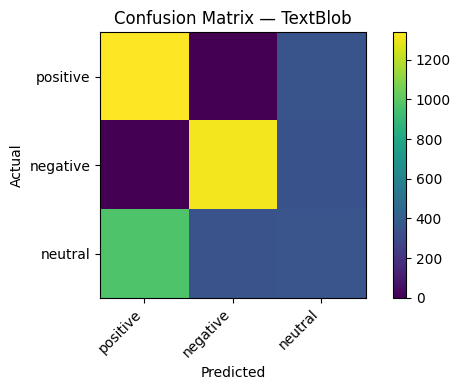

In [23]:
#compare with ground truth labels

labels = ["positive", "negative", "neutral"]

tb_accuracy = accuracy_score(data["sentiment"], data["tb_label"])
tb_cm = confusion_matrix(data["sentiment"], data["tb_label"], labels=labels)

print(f"\n3) Evaluation — Accuracy: {tb_accuracy:.4f}")
print("Confusion Matrix (rows=Actual, cols=Predicted):\n", tb_cm)

# Plot confusion matrix (no annotation loop; just imshow + ticks)
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(tb_cm)  # default colormap, no style set
ax.set_title("Confusion Matrix — TextBlob")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

In [36]:
#interpretation and reflection 

wrong = data.loc[data["sentiment"] != data["tb_label"],
               ["tweet_id", "company", "tweet_text", "sentiment", "tb_label", "tb_polarity"]]
wrong_sample = wrong.head(12)

print("\n4) Misclassified Examples (first 12):")
print(wrong_sample.to_string(index=False))

# Simple issue flags (vectorised, no loops)
sarcasm_markers = ["yeah right", "sure", "totally", "great...", "/s", "as if"]
sarcasm_regex = r"|".join([re.escape(s) for s in sarcasm_markers])

sarcasm_flag = data["cleaned_tweet"].str.contains(sarcasm_regex, regex=True, na=False)

pos_words = ["good", "great", "amazing", "love", "happy", "best"]
neg_words = ["bad", "terrible", "hate", "worst", "awful", "disappoint"]
pos_regex = r"|".join([rf"\b{re.escape(w)}\b" for w in pos_words])
neg_regex = r"|".join([rf"\b{re.escape(w)}\b" for w in neg_words])

has_pos = data["cleaned_tweet"].str.contains(pos_regex, regex=True, na=False)
has_neg = data["cleaned_tweet"].str.contains(neg_regex, regex=True, na=False)
mixed_sentiment_flag = has_pos & has_neg

near_zero = data["tb_polarity"].abs() < 0.05
neutrality_conflict = (near_zero & (data["sentiment"] != "neutral")) | ((~near_zero) & (data["sentiment"] == "neutral"))

issue_summary = pd.DataFrame(
    {
        "possible_sarcasm": [sarcasm_flag.sum()],
        "possible_mixed": [mixed_sentiment_flag.sum()],
        "neutrality_conflict": [neutrality_conflict.sum()],
    }
).T
issue_summary.columns = ["count"]

print("Common-Issue Heuristics (rough counts):")
print(issue_summary.to_string())




4) Misclassified Examples (first 12):
 tweet_id   company                                           tweet_text sentiment tb_label  tb_polarity
        1     Apple Apple's performance is top-notch. Kudos to the team!  positive  neutral     0.000000
        3     Apple           Still exploring Apple. Too early to judge.   neutral positive     0.100000
        8    Google          Still exploring Google. Too early to judge.   neutral positive     0.100000
       15    Amazon       Amazon update broke everything. Please fix it!  negative  neutral     0.000000
       18     Apple            Not good, not bad. Apple is just average.   neutral negative    -0.050000
       19      Meta         Meta update broke everything. Please fix it!  negative  neutral     0.000000
       20    Google     I used Google today. It's okay, nothing special.   neutral positive     0.428571
       21     Apple              Apple works fine, just the usual stuff.   neutral positive     0.083333
       24 Micros

In [41]:
print(f"- Overall performance: Accuracy: {tb_accuracy:.1%}.")

- Overall performance: Accuracy: 60.1%.


In [ ]:
#Questions:

#1. Overall performance: Accuracy 60.1%. Good on clear positives; weaker on neutral/nuanced text.
#2. Wrongly predicted tweets: see the table above.
#3. Common issues: sarcasm/irony, mixed sentiment in one tweet, and slight-positive wording tagged as neutral (or vice versa).
#4. Prefer rule-based methods when you need speed, zero training data, or a quick baseline; prefer ML for nuance/context and higher accuracy.

In [ ]:
#How do rule based sentiments tools like TextBlob and Vader work?
#Rule based tools use predefined lexicons of words with associated sentiment scores (positive, negative, neutral). When you input text, they look up these words in the lexicon, add up or average the scores, and apply simple rules (e.g., negation handling, intensifiers). TextBlob uses a polarity scale from -1 (negative) to +1 (positive), while VADER uses tuned for social media text and uses special weights for things like capitalization, punctuation, and degree modifiers (e.g., "very", "extremely").

#What are the limitations of rule-based sentiment analysis?
#The main limitation is that they can't understand context, sarcasm, or nuanced language. They rely on fixed word lists and simple rules, so they may misinterpret phrases where sentiment depends on context (e.g., "I love waiting in long lines" is sarcastic). They also struggle with mixed sentiments in one text and may not adapt well to new slang or evolving language use. Overall, they tend to be less accurate than machine learning approaches that can learn from data.